# MAROUANE ZAIZOUNE
# Data science Internship
# LetsGrowMore
# Advanced Level
# Task 8: Next Word Prediction

## Importing libraries

In [1]:
import numpy as np
import tensorflow as tf

from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

## Loading the Dataset

In [2]:
path = '1661-0.txt'
text = open(path).read().lower()
print('corpus length:', len(text))

corpus length: 581888


In [3]:
tokenizer = RegexpTokenizer(r'w+')
words = tokenizer.tokenize(text)

In [4]:
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

## Feature Engineering

In [5]:
character = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(character))
indices_char = dict((i, c) for i, c in enumerate(character))
 
print(f'unique chars: {len(character)}')

unique chars: 73


In [6]:
#chunk 40 characters with 3 sequences
seq_len = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - seq_len, step):
    sentences.append(text[i: i + seq_len ])
    next_chars.append(text[i + seq_len])
print(f'num training examples: {len(sentences)}')

num training examples: 193950


In [7]:
# generating our features and labels
#one hot encoding
X = np.zeros((len(sentences), seq_len, len(character)), dtype=np.bool)
Y = np.zeros((len(sentences), len(character)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    Y[i, char_indices[next_chars[i]]] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


In [8]:
X.shape

(193950, 40, 73)

In [9]:
Y.shape

(193950, 73)

In [10]:
print(X[0][0])

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True]


## Building the Recurrent Neural network

In [11]:
model = Sequential()
model.add(LSTM(128, input_shape=(seq_len, len(character))))
model.add(Dense(len(character)))
model.add(Activation('softmax'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               103424    
                                                                 
 dense (Dense)               (None, 73)                9417      
                                                                 
 activation (Activation)     (None, 73)                0         
                                                                 
Total params: 112,841
Trainable params: 112,841
Non-trainable params: 0
_________________________________________________________________


## Training the Next Word Prediction Model

In [13]:
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=10, shuffle=True).history

Epoch 1/10
1440/1440 [==============================] - 184s 126ms/step - loss: 1.9549 - accuracy: 0.4257 - val_loss: 2.1169 - val_accuracy: 0.4175
Epoch 2/10
1440/1440 [==============================] - 179s 124ms/step - loss: 1.6109 - accuracy: 0.5169 - val_loss: 2.0417 - val_accuracy: 0.4390
Epoch 3/10
1440/1440 [==============================] - 179s 124ms/step - loss: 1.5143 - accuracy: 0.5439 - val_loss: 2.0301 - val_accuracy: 0.4556
Epoch 4/10
1440/1440 [==============================] - 179s 125ms/step - loss: 1.4636 - accuracy: 0.5576 - val_loss: 2.0260 - val_accuracy: 0.4603
Epoch 5/10
1440/1440 [==============================] - 180s 125ms/step - loss: 1.4288 - accuracy: 0.5668 - val_loss: 2.0025 - val_accuracy: 0.4562
Epoch 6/10
1440/1440 [==============================] - 181s 125ms/step - loss: 1.4056 - accuracy: 0.5721 - val_loss: 2.0216 - val_accuracy: 0.4645
Epoch 7/10
1440/1440 [==============================] - 181s 125ms/step - loss: 1.3876 - accuracy: 0.5777 - val_

## Evaluating the Next Word Prediction Model

In [14]:
loss_and_acc=model.evaluate(X,Y)
print("Test Loss", loss_and_acc[0])
print("Test Accuracy", loss_and_acc[1])

6061/6061 [==============================] - 95s 16ms/step - loss: 1.3403 - accuracy: 0.5933
Test Loss 1.3402856588363647
Test Accuracy 0.5933384895324707


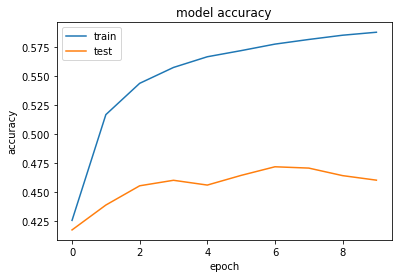

In [15]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

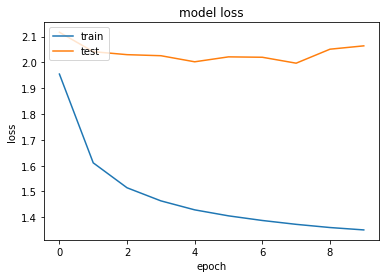

In [16]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

## Testing Next Word Prediction Model

In [17]:
def prepare_input(text):
    x = np.zeros((1, seq_len, len(character)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [18]:
prepare_input("This is an example of input for our LSTM".lower())

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

**Defining the functions to get next probable characters**

In [19]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [20]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [21]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

## Prediction

In [22]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "Recurrent neural network (RNN) is a type of artificial neural network which uses sequential data or time series data.",
    "Thanks for spending your precious time to view my work.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]

In [23]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

it is not a lack of love, but a lack of 
['the ', 'a ', 'his ', 'court ', 'my ']

recurrent neural network (rnn) is a type
['writ ', 'pred ', 'mechief ', 'ster ', 'lape ']

thanks for spending your precious time t
['o ', 'hat ', 'races ', 'urned ', 'ime ']

and those who were seen dancing were tho
['ugh ', 'se ', 'oe ', 're ', 'w ']

it is hard enough to remember my opinion
[' of ', 's ', '. ', ', ', '\nwith ']

